In [121]:
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
from torch.optim import Adam
import math
import pdb
from pathlib import Path

In [107]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, device='cpu'):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

In [108]:
T = 300
betas = linear_beta_schedule(timesteps=T)

alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

In [109]:
IMG_SIZE = 128
BATCH_SIZE = 64

def load_transformed_dataset():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(), # normalizes data between [0,1]
        transforms.Lambda(lambda t: (t*2) - 1) # Scale to [-1, 1] to work with the betas
    ]

    data_transform = transforms.Compose(data_transforms)

    train = torchvision.datasets.Flowers102(root='./data/', download=False, transform=data_transform)
    test = torchvision.datasets.Flowers102(root='./data/', download=False, transform=data_transform, split='test')
    
    return torch.utils.data.ConcatDataset([train, test])

def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t+1) / 2), # Scale to [-1, 1]
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    img = reverse_transforms(image)
    plt.imshow(img)

data = load_transformed_dataset()
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

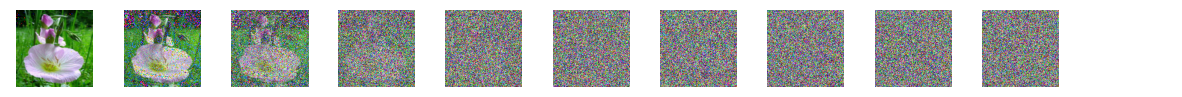

In [110]:
image = next(iter(dataloader))[0]

plt.figure(figsize=(15,1))
plt.axis('off')
num_images = 10
stepsize = int(T/num_images)

for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize)+1)
    plt.axis('off')
    image, noise = forward_diffusion_sample(image, t)
    show_tensor_image(image)

In [98]:
# Unets are special type of networks where the output size is same as the input
# They are popularly used for image segmentation 
# Input undergoes convolutional and downsampling operations until a bottleneck is reached
# Input is passed through deeper layers (more channels)
# Typical components that are a part of UNets : Residual connections, group normalizations and attention modules

# They are perfect for image data and for denoising process
# The model outputs one value per pixel - mean of the gaussian distribution, variance is fixed. This is also known as Denoising Score Matching
# We need to tell the model which timestep we are on because it uses the same shared weights for all inputs. Therefore, positional embeddings is also passed to the model at several different parts of the network


In [99]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [100]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)

In [101]:
class SimpleUnet(nn.Module):
    """
    A simplified variant of the UNet architecture
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = [64, 128, 256, 512, 1024]
        up_channels = [1024, 512, 256, 128, 64]
        time_embedding_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_embedding_dim),
            nn.Linear(time_embedding_dim, time_embedding_dim),
            nn.ReLU()
        )
    
        # Initial Projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
    
        # Downsample
        self.downsampling_nw = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_embedding_dim) for i in range(len(down_channels) - 1)])
    
        self.upsampling_nw = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_embedding_dim, up=True) for i in range(len(up_channels) - 1)])
    
        self.output = nn.Conv2d(up_channels[-1], image_channels, 1)

    def forward(self, x, timestep):
        # Embed time
        t = self.time_mlp(timestep)
        # Initial convolutional layer
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downsampling_nw:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.upsampling_nw:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print('Num params: ', sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downsampling_nw): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [102]:
# The loss

def get_loss(model, x_0, t):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [123]:
# Sampling

@torch.no_grad()
def sample_timestep(x, t):
    
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)

    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t==0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def sample_plot_image(fname):
    # sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15,1))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize+1))
            plt.axis('off')
            show_tensor_image(img.detach().cpu())
    plt.savefig(fname, bbox_inches='tight')

Epoch 0 | step 000 Loss : 0.41576915979385376


KeyboardInterrupt: 

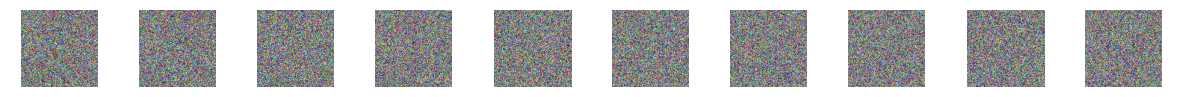

In [125]:
# Training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 1000

Path("./results").mkdir(parents=True, exist_ok=True)

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f'Epoch {epoch} | step {step:03d} Loss : {loss.item()}')
            sample_plot_image('./results/Epoch_' + str(epoch))        